# Sarcasm Detection Using NLP

This notebook demonstrates a complete NLP pipeline for detecting sarcasm in news headlines.

## Table of Contents
1. Data Loading and Initial Exploration
2. Data Preprocessing
3. Exploratory Data Analysis
4. Feature Engineering
5. Model Training
6. Model Evaluation
7. Predictions and Insights

## Step 1: Import Required Libraries

In [29]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import warnings
warnings.filterwarnings('ignore')

# NLP libraries
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

# Download required NLTK data
nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)
nltk.download('averaged_perceptron_tagger', quiet=True)

# Machine Learning libraries
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve

plt.style.use('default')
# sns.set_palette('husl')

## Step 2: Load the Data

In [30]:
# Load the sarcasm dataset
with open('sarcasm.json', 'r') as f:
    data = json.load(f)

# Convert to DataFrame
df = pd.DataFrame(data)

# Display basic information
print(f'Dataset shape: {df.shape}')
print(f'\nColumn names: {df.columns.tolist()}')
print(f'\nFirst few rows:')
df.head()

Dataset shape: (26709, 3)

Column names: ['article_link', 'headline', 'is_sarcastic']

First few rows:


,article_link,headline,is_sarcastic
0,https://www.huffingtonpost.com/entry/versace-b...,former versace store clerk sues over secret 'b...,0
1,https://www.huffingtonpost.com/entry/roseanne-...,the 'roseanne' revival catches up to our thorn...,0
2,https://local.theonion.com/mom-starting-to-fea...,mom starting to fear son's web series closest ...,1
3,https://politics.theonion.com/boehner-just-wan...,"boehner just wants wife to listen, not come up...",1
4,https://www.huffingtonpost.com/entry/jk-rowlin...,j.k. rowling wishes snape happy birthday in th...,0


## Step 3: Initial Data Exploration

In [31]:
# Check dataset info
print('Dataset Information:')
print(df.info())

print('\n' + '='*50 + '\n')

# Check for missing values
print('Missing Values:')
print(df.isnull().sum())

print('\n' + '='*50 + '\n')

# Statistics
print('Dataset Statistics:')
print(df.describe())

Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26709 entries, 0 to 26708
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   article_link  26709 non-null  object
 1   headline      26709 non-null  object
 2   is_sarcastic  26709 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 626.1+ KB
None


Missing Values:
article_link    0
headline        0
is_sarcastic    0
dtype: int64


Dataset Statistics:
       is_sarcastic
count  26709.000000
mean       0.438953
std        0.496269
min        0.000000
25%        0.000000
50%        0.000000
75%        1.000000
max        1.000000


Class Distribution:
is_sarcastic
0    14985
1    11724
Name: count, dtype: int64

Class Percentages:
is_sarcastic
0    56.104684
1    43.895316
Name: proportion, dtype: float64


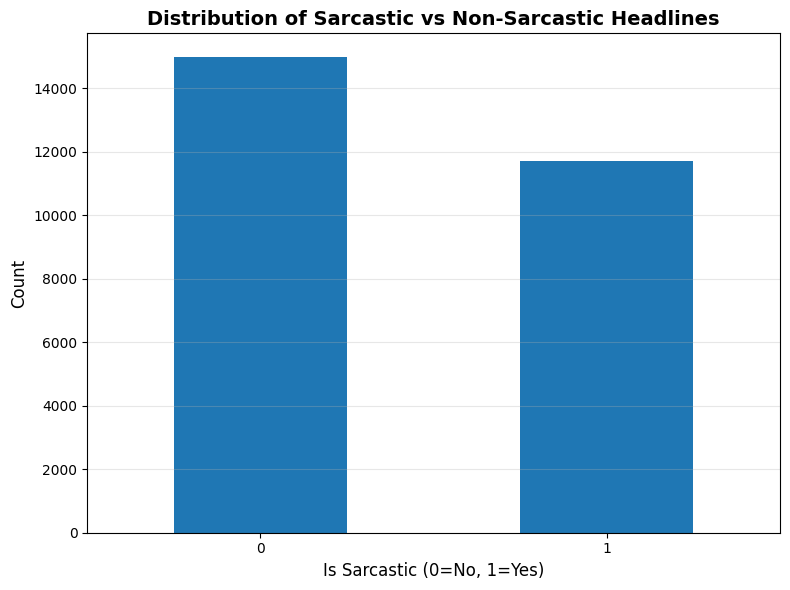

In [32]:
# Check class distribution
print('Class Distribution:')
print(df['is_sarcastic'].value_counts())
print('\nClass Percentages:')
print(df['is_sarcastic'].value_counts(normalize=True) * 100)

# Visualize class distribution
plt.figure(figsize=(8, 6))
df['is_sarcastic'].value_counts().plot(kind='bar', color='#1f77b4')
plt.title('Distribution of Sarcastic vs Non-Sarcastic Headlines', fontsize=14, fontweight='bold')
plt.xlabel('Is Sarcastic (0=No, 1=Yes)', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=0)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

## Step 4: Text Preprocessing

In [33]:
# Define preprocessing functions
def clean_text(text):
    """Clean and normalize text"""
    # Convert to lowercase
    text = text.lower()
    
    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    
    # Remove special characters and digits
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    
    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    
    return text

def tokenize_text(text):
    """Tokenize text into words"""
    return word_tokenize(text)

def remove_stopwords(tokens):
    """Remove stopwords from token list"""
    stop_words = set(stopwords.words('english'))
    return [word for word in tokens if word not in stop_words]

def lemmatize_tokens(tokens):
    """Lemmatize tokens"""
    lemmatizer = WordNetLemmatizer()
    return [lemmatizer.lemmatize(word) for word in tokens]

def preprocess_text(text):
    """Complete preprocessing pipeline"""
    text = clean_text(text)
    tokens = tokenize_text(text)
    tokens = remove_stopwords(tokens)
    tokens = lemmatize_tokens(tokens)
    return ' '.join(tokens)

print('Preprocessing functions defined successfully')

Preprocessing functions defined successfully


In [34]:
# Apply preprocessing
print('Preprocessing headlines...')
df['cleaned_headline'] = df['headline'].apply(preprocess_text)

# Show examples of original vs cleaned text
print('\nExamples of Original vs Cleaned Headlines:')
for i in range(5):
    print(f'\nExample {i+1}:')
    print(f'Original: {df.iloc[i]["headline"]}')
    print(f'Cleaned: {df.iloc[i]["cleaned_headline"]}')
    print('-' * 80)

Preprocessing headlines...

Examples of Original vs Cleaned Headlines:

Example 1:
Original: former versace store clerk sues over secret 'black code' for minority shoppers
Cleaned: former versace store clerk sue secret black code minority shopper
--------------------------------------------------------------------------------

Example 2:
Original: the 'roseanne' revival catches up to our thorny political mood, for better and worse
Cleaned: roseanne revival catch thorny political mood better worse
--------------------------------------------------------------------------------

Example 3:
Original: mom starting to fear son's web series closest thing she will have to grandchild
Cleaned: mom starting fear son web series closest thing grandchild
--------------------------------------------------------------------------------

Example 4:
Original: boehner just wants wife to listen, not come up with alternative debt-reduction ideas
Cleaned: boehner want wife listen come alternative debtreduc

## Step 5: Exploratory Data Analysis

In [35]:
# Calculate text length statistics
df['text_length'] = df['cleaned_headline'].apply(len)
df['word_count'] = df['cleaned_headline'].apply(lambda x: len(x.split()))

# Compare statistics for sarcastic vs non-sarcastic
print('Text Length Statistics by Class:')
print(df.groupby('is_sarcastic')[['text_length', 'word_count']].describe())

Text Length Statistics by Class:
             text_length                                                      \
                   count       mean        std  min   25%   50%   75%    max   
is_sarcastic                                                                   
0                14985.0  45.404137  15.356957  0.0  35.0  46.0  56.0  152.0   
1                11724.0  50.742494  17.251717  3.0  39.0  50.0  62.0  226.0   

             word_count                                                
                  count      mean       std  min  25%  50%  75%   max  
is_sarcastic                                                           
0               14985.0  6.711645  2.171182  0.0  5.0  7.0  8.0  19.0  
1               11724.0  7.329324  2.344862  1.0  6.0  7.0  9.0  26.0  


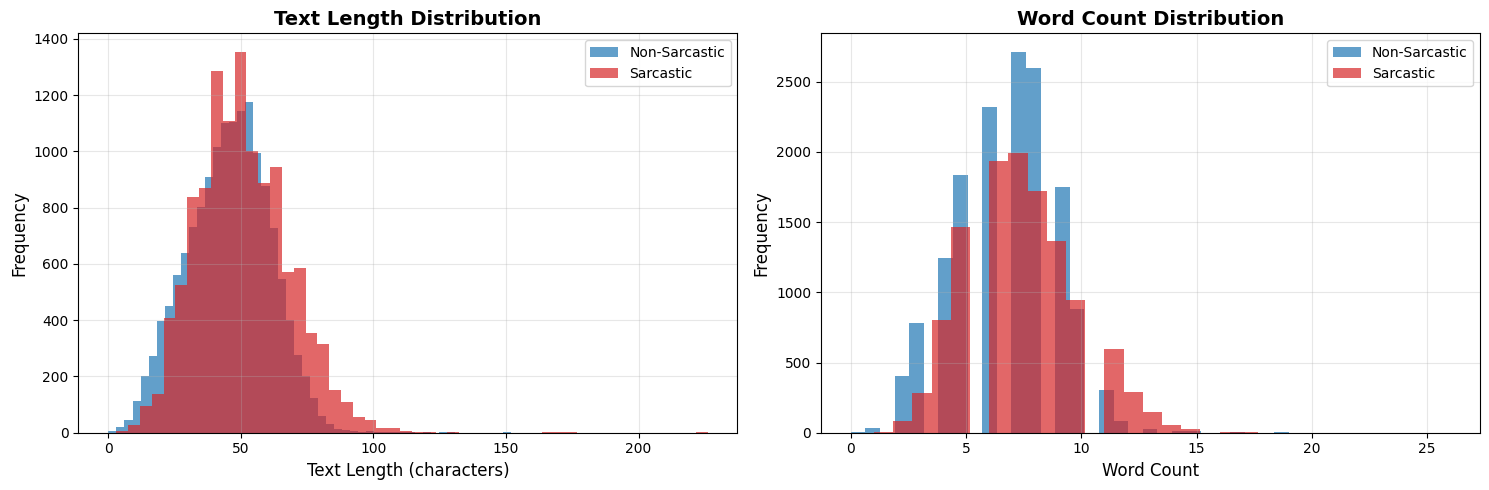

In [36]:
# Visualize text length distribution
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Text length distribution
df[df['is_sarcastic']==0]['text_length'].hist(bins=50, alpha=0.7, label='Non-Sarcastic', ax=axes[0], color='#1f77b4')
df[df['is_sarcastic']==1]['text_length'].hist(bins=50, alpha=0.7, label='Sarcastic', ax=axes[0], color='#d62728')
axes[0].set_title('Text Length Distribution', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Text Length (characters)', fontsize=12)
axes[0].set_ylabel('Frequency', fontsize=12)
axes[0].legend()
axes[0].grid(alpha=0.3)

# Word count distribution
df[df['is_sarcastic']==0]['word_count'].hist(bins=30, alpha=0.7, label='Non-Sarcastic', ax=axes[1], color='#1f77b4')
df[df['is_sarcastic']==1]['word_count'].hist(bins=30, alpha=0.7, label='Sarcastic', ax=axes[1], color='#d62728')
axes[1].set_title('Word Count Distribution', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Word Count', fontsize=12)
axes[1].set_ylabel('Frequency', fontsize=12)
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

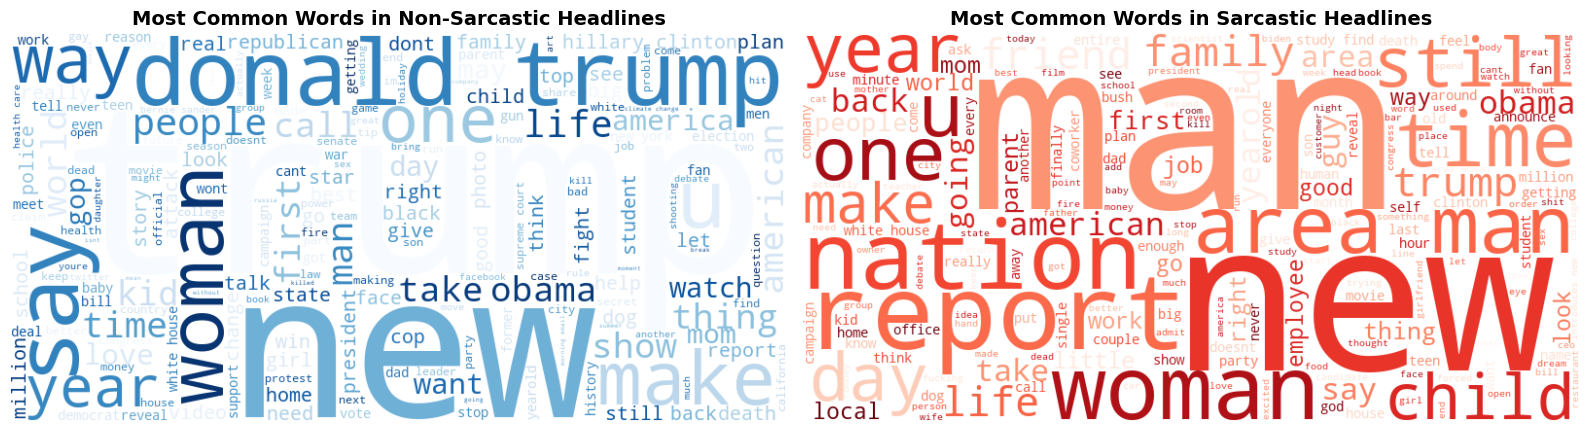

In [37]:
# Generate word clouds
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Word cloud for non-sarcastic headlines
non_sarcastic_text = ' '.join(df[df['is_sarcastic']==0]['cleaned_headline'])
wordcloud_non_sarcastic = WordCloud(width=800, height=400, 
                                     background_color='white', 
                                     colormap='Blues').generate(non_sarcastic_text)
axes[0].imshow(wordcloud_non_sarcastic, interpolation='bilinear')
axes[0].set_title('Most Common Words in Non-Sarcastic Headlines', fontsize=14, fontweight='bold')
axes[0].axis('off')

# Word cloud for sarcastic headlines
sarcastic_text = ' '.join(df[df['is_sarcastic']==1]['cleaned_headline'])
wordcloud_sarcastic = WordCloud(width=800, height=400, 
                                 background_color='white', 
                                 colormap='Reds').generate(sarcastic_text)
axes[1].imshow(wordcloud_sarcastic, interpolation='bilinear')
axes[1].set_title('Most Common Words in Sarcastic Headlines', fontsize=14, fontweight='bold')
axes[1].axis('off')

plt.tight_layout()
plt.show()

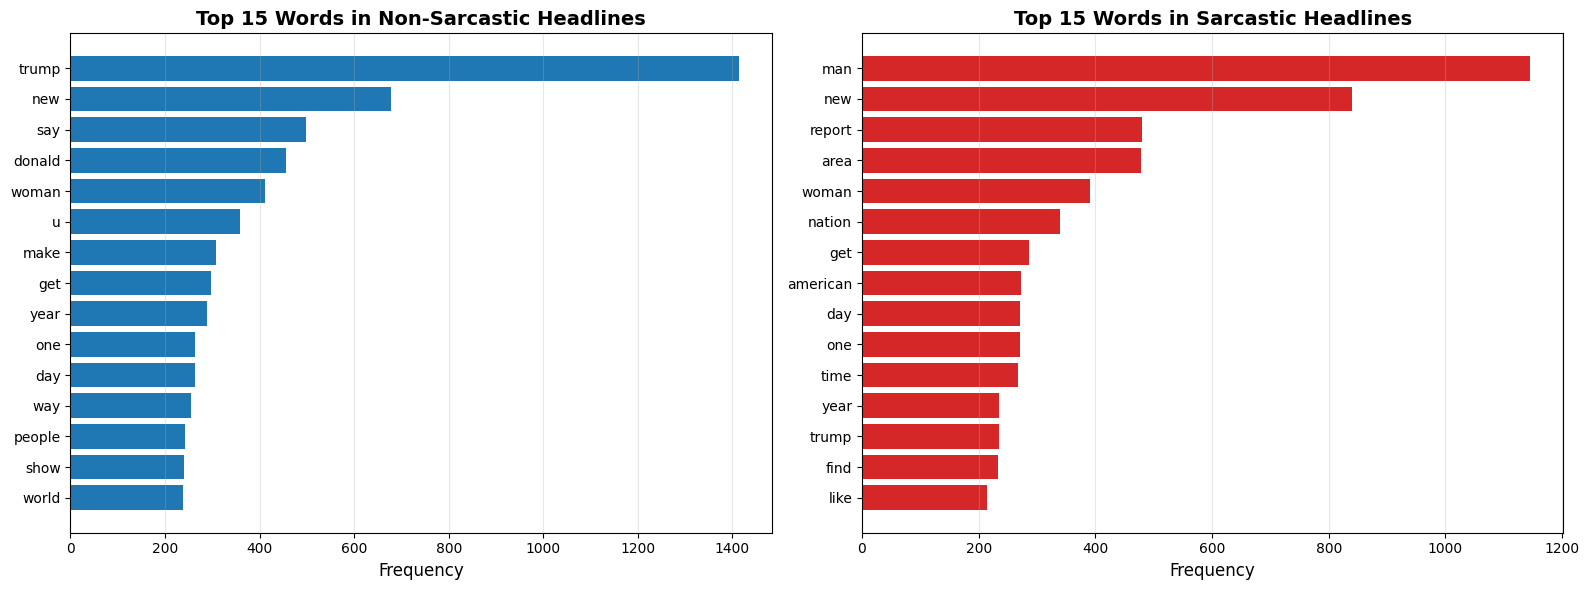

In [38]:
# Most common words analysis
from collections import Counter

def get_top_words(text_series, n=20):
    """Get top N most common words"""
    all_words = ' '.join(text_series).split()
    return Counter(all_words).most_common(n)

# Top words for each class
top_non_sarcastic = get_top_words(df[df['is_sarcastic']==0]['cleaned_headline'], 15)
top_sarcastic = get_top_words(df[df['is_sarcastic']==1]['cleaned_headline'], 15)

# Plot top words
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Non-sarcastic top words
words, counts = zip(*top_non_sarcastic)
axes[0].barh(words, counts, color='#1f77b4')
axes[0].set_title('Top 15 Words in Non-Sarcastic Headlines', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Frequency', fontsize=12)
axes[0].invert_yaxis()
axes[0].grid(axis='x', alpha=0.3)

# Sarcastic top words
words, counts = zip(*top_sarcastic)
axes[1].barh(words, counts, color='#d62728')
axes[1].set_title('Top 15 Words in Sarcastic Headlines', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Frequency', fontsize=12)
axes[1].invert_yaxis()
axes[1].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

## Step 6: Feature Engineering with TF-IDF

In [39]:
# Prepare data for modeling
X = df['cleaned_headline']
y = df['is_sarcastic']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f'Training set size: {len(X_train)}')
print(f'Testing set size: {len(X_test)}')
print(f'\nClass distribution in training set:')
print(y_train.value_counts())
print(f'\nClass distribution in testing set:')
print(y_test.value_counts())

Training set size: 21367
Testing set size: 5342

Class distribution in training set:
is_sarcastic
0    11988
1     9379
Name: count, dtype: int64

Class distribution in testing set:
is_sarcastic
0    2997
1    2345
Name: count, dtype: int64


In [40]:
# Create TF-IDF features
tfidf_vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1, 2))

# Fit and transform training data
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)

# Transform testing data
X_test_tfidf = tfidf_vectorizer.transform(X_test)

print(f'TF-IDF feature shape (training): {X_train_tfidf.shape}')
print(f'TF-IDF feature shape (testing): {X_test_tfidf.shape}')
print(f'\nVocabulary size: {len(tfidf_vectorizer.vocabulary_)}')

TF-IDF feature shape (training): (21367, 5000)
TF-IDF feature shape (testing): (5342, 5000)

Vocabulary size: 5000


## Step 7: Model Training

We will train multiple models and compare their performance.

In [41]:
# Define models to train
models = {
    'Naive Bayes': MultinomialNB(),
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
}

# Train models and store results
results = {}

for name, model in models.items():
    print(f'Training {name}...')
    model.fit(X_train_tfidf, y_train)
    
    # Make predictions
    y_pred = model.predict(X_test_tfidf)
    y_pred_proba = model.predict_proba(X_test_tfidf)[:, 1] if hasattr(model, 'predict_proba') else None
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    
    results[name] = {
        'model': model,
        'y_pred': y_pred,
        'y_pred_proba': y_pred_proba,
        'accuracy': accuracy
    }
    
    print(f'{name} Accuracy: {accuracy:.4f}')
    print('-' * 50)

Training Naive Bayes...
Naive Bayes Accuracy: 0.7896
--------------------------------------------------
Training Logistic Regression...
Logistic Regression Accuracy: 0.7860
--------------------------------------------------
Training Random Forest...
Random Forest Accuracy: 0.7641
--------------------------------------------------


## Step 8: Model Evaluation

Model Comparison:
                 Model  Accuracy
0          Naive Bayes  0.789592
1  Logistic Regression  0.786035
2        Random Forest  0.764133


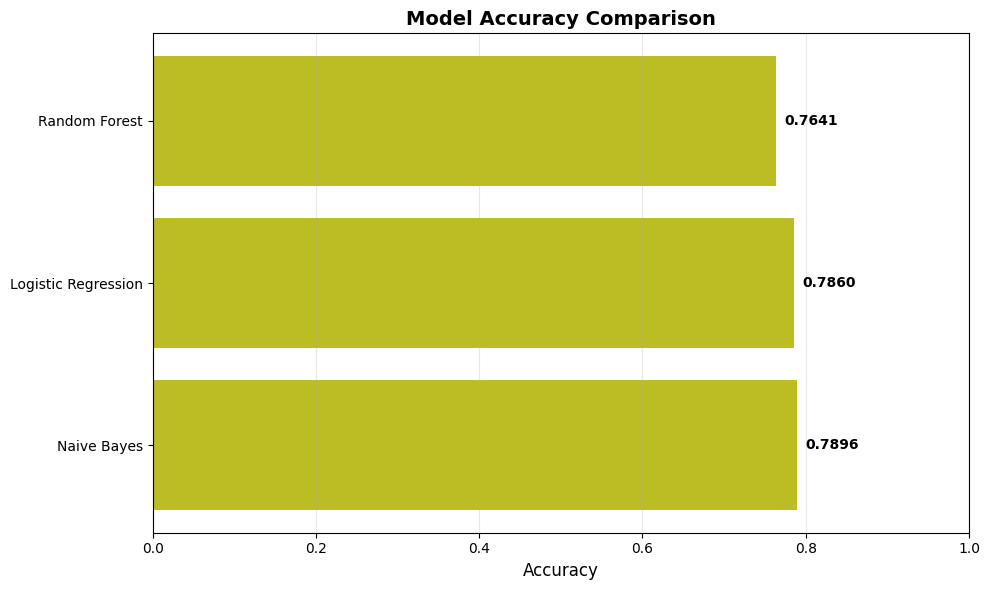

In [42]:
# Compare model accuracies
accuracy_df = pd.DataFrame({
    'Model': list(results.keys()),
    'Accuracy': [results[model]['accuracy'] for model in results.keys()]
}).sort_values('Accuracy', ascending=False)

print('Model Comparison:')
print(accuracy_df)

# Plot accuracy comparison
plt.figure(figsize=(10, 6))
plt.barh(accuracy_df['Model'], accuracy_df['Accuracy'], color='#bcbd22')
plt.xlabel('Accuracy', fontsize=12)
plt.title('Model Accuracy Comparison', fontsize=14, fontweight='bold')
plt.xlim([0, 1])
plt.grid(axis='x', alpha=0.3)

# Add value labels
for i, v in enumerate(accuracy_df['Accuracy']):
    plt.text(v + 0.01, i, f'{v:.4f}', va='center', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

In [43]:
# Detailed classification reports
for name, result in results.items():
    print(f'\n{"="*70}')
    print(f'{name} - Detailed Classification Report')
    print(f'{"="*70}')
    print(classification_report(y_test, result['y_pred'], 
                                target_names=['Non-Sarcastic', 'Sarcastic']))


Naive Bayes - Detailed Classification Report
               precision    recall  f1-score   support

Non-Sarcastic       0.79      0.86      0.82      2997
    Sarcastic       0.80      0.70      0.74      2345

     accuracy                           0.79      5342
    macro avg       0.79      0.78      0.78      5342
 weighted avg       0.79      0.79      0.79      5342


Logistic Regression - Detailed Classification Report
               precision    recall  f1-score   support

Non-Sarcastic       0.78      0.86      0.82      2997
    Sarcastic       0.80      0.69      0.74      2345

     accuracy                           0.79      5342
    macro avg       0.79      0.78      0.78      5342
 weighted avg       0.79      0.79      0.78      5342


Random Forest - Detailed Classification Report
               precision    recall  f1-score   support

Non-Sarcastic       0.77      0.82      0.80      2997
    Sarcastic       0.75      0.69      0.72      2345

     accuracy      

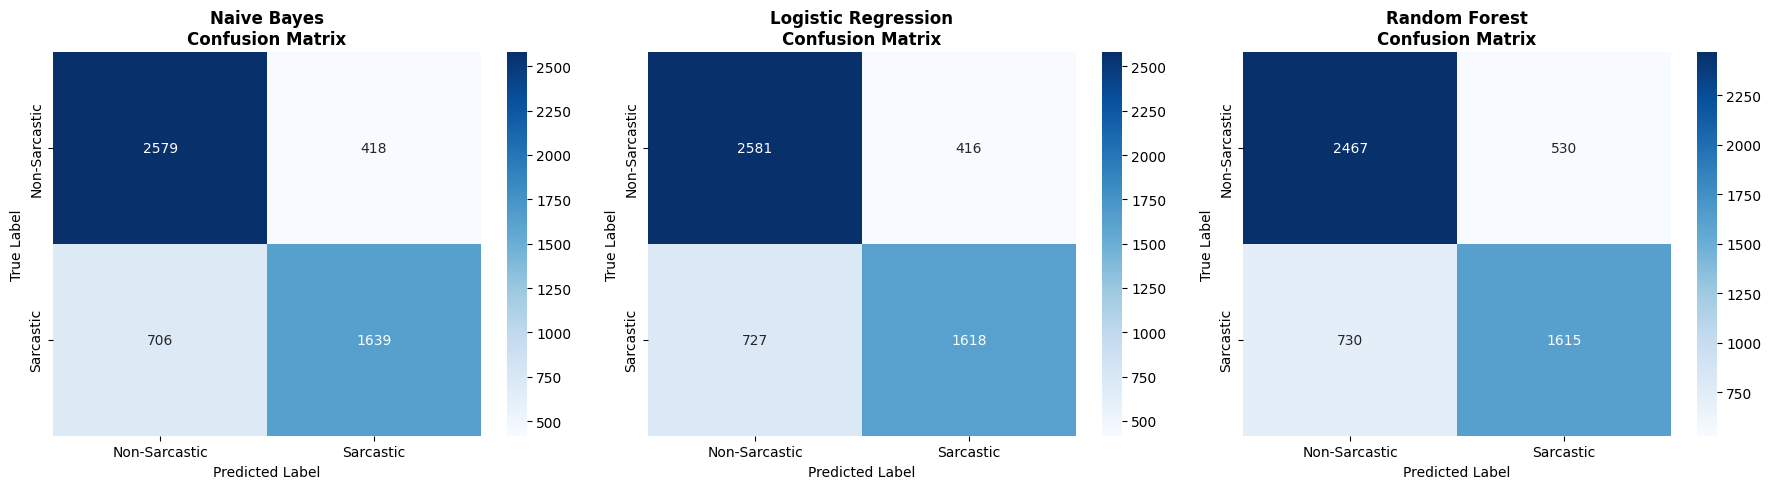

In [44]:
# Confusion matrices
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, (name, result) in enumerate(results.items()):
    cm = confusion_matrix(y_test, result['y_pred'])
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[idx],
                xticklabels=['Non-Sarcastic', 'Sarcastic'],
                yticklabels=['Non-Sarcastic', 'Sarcastic'])
    axes[idx].set_title(f'{name}\nConfusion Matrix', fontsize=12, fontweight='bold')
    axes[idx].set_ylabel('True Label', fontsize=10)
    axes[idx].set_xlabel('Predicted Label', fontsize=10)

plt.tight_layout()
plt.show()

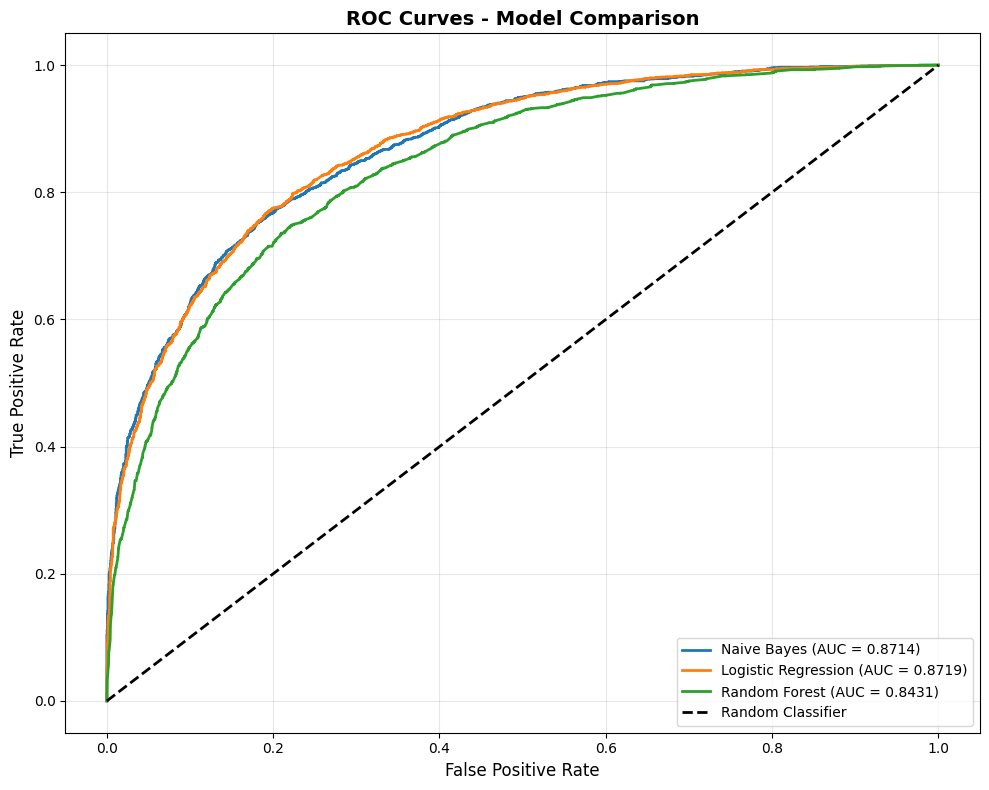

In [45]:
# ROC curves
plt.figure(figsize=(10, 8))

for name, result in results.items():
    if result['y_pred_proba'] is not None:
        fpr, tpr, _ = roc_curve(y_test, result['y_pred_proba'])
        roc_auc = roc_auc_score(y_test, result['y_pred_proba'])
        plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.4f})', linewidth=2)

plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier', linewidth=2)
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves - Model Comparison', fontsize=14, fontweight='bold')
plt.legend(loc='lower right', fontsize=10)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

## Step 9: Feature Importance Analysis

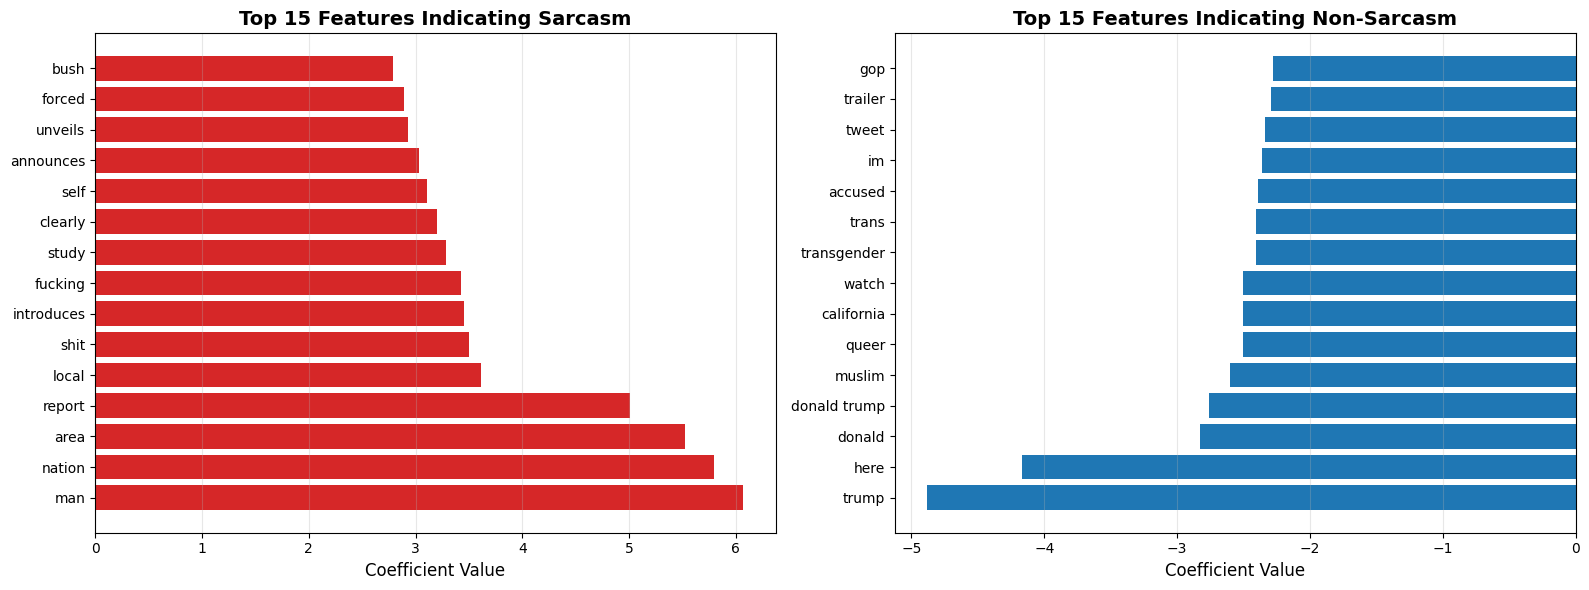

In [46]:
# Get feature importance from Logistic Regression
lr_model = results['Logistic Regression']['model']
feature_names = tfidf_vectorizer.get_feature_names_out()
coefficients = lr_model.coef_[0]

# Get top features for each class
top_n = 15

# Top features indicating sarcasm (positive coefficients)
top_sarcastic_indices = np.argsort(coefficients)[-top_n:]
top_sarcastic_features = [(feature_names[i], coefficients[i]) for i in top_sarcastic_indices]

# Top features indicating non-sarcasm (negative coefficients)
top_non_sarcastic_indices = np.argsort(coefficients)[:top_n]
top_non_sarcastic_features = [(feature_names[i], coefficients[i]) for i in top_non_sarcastic_indices]

# Visualize feature importance
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Sarcastic features
features, coefs = zip(*reversed(top_sarcastic_features))
axes[0].barh(features, coefs, color='#d62728')
axes[0].set_title('Top 15 Features Indicating Sarcasm', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Coefficient Value', fontsize=12)
axes[0].grid(axis='x', alpha=0.3)

# Non-sarcastic features
features, coefs = zip(*top_non_sarcastic_features)
axes[1].barh(features, coefs, color='#1f77b4')
axes[1].set_title('Top 15 Features Indicating Non-Sarcasm', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Coefficient Value', fontsize=12)
axes[1].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

## Step 10: Predictions on New Examples

In [47]:
# Select the best model
best_model_name = accuracy_df.iloc[0]['Model']
best_model = results[best_model_name]['model']

print(f'Using best model: {best_model_name}\n')

def predict_sarcasm(headline):
    """Predict whether a headline is sarcastic"""
    # Preprocess
    cleaned = preprocess_text(headline)
    
    # Vectorize
    vectorized = tfidf_vectorizer.transform([cleaned])
    
    # Predict
    prediction = best_model.predict(vectorized)[0]
    probability = best_model.predict_proba(vectorized)[0]
    
    return {
        'headline': headline,
        'is_sarcastic': bool(prediction),
        'confidence': probability[prediction],
        'probabilities': {
            'non_sarcastic': probability[0],
            'sarcastic': probability[1]
        }
    }

# Test with example headlines
test_headlines = [
    "President announces new healthcare reform",
    "Area man successfully avoids talking to neighbor for 10th consecutive day",
    "Scientists discover new species of butterfly in Amazon rainforest",
    "Nation's economists announce recession is over for wealthy people",
    "Local woman finally finds perfect work-life balance at age 97"
]

print('Predictions on new examples:')
print('='*80)
for headline in test_headlines:
    result = predict_sarcasm(headline)
    print(f"\nHeadline: {result['headline']}")
    print(f"Prediction: {'Sarcastic' if result['is_sarcastic'] else 'Non-Sarcastic'}")
    print(f"Confidence: {result['confidence']:.4f}")
    print(f"Probabilities - Non-Sarcastic: {result['probabilities']['non_sarcastic']:.4f}, "
          f"Sarcastic: {result['probabilities']['sarcastic']:.4f}")
    print('-' * 80)

Using best model: Naive Bayes

Predictions on new examples:

Headline: President announces new healthcare reform
Prediction: Sarcastic
Confidence: 0.5147
Probabilities - Non-Sarcastic: 0.4853, Sarcastic: 0.5147
--------------------------------------------------------------------------------

Headline: Area man successfully avoids talking to neighbor for 10th consecutive day
Prediction: Sarcastic
Confidence: 0.9817
Probabilities - Non-Sarcastic: 0.0183, Sarcastic: 0.9817
--------------------------------------------------------------------------------

Headline: Scientists discover new species of butterfly in Amazon rainforest
Prediction: Sarcastic
Confidence: 0.8900
Probabilities - Non-Sarcastic: 0.1100, Sarcastic: 0.8900
--------------------------------------------------------------------------------

Headline: Nation's economists announce recession is over for wealthy people
Prediction: Sarcastic
Confidence: 0.9172
Probabilities - Non-Sarcastic: 0.0828, Sarcastic: 0.9172
-------------

## Step 11: Summary and Insights

In [48]:
print('SUMMARY OF FINDINGS')
print('='*80)
print(f'\n1. Dataset Statistics:')
print(f'   - Total headlines: {len(df)}')
print(f'   - Sarcastic: {(df["is_sarcastic"]==1).sum()} ({(df["is_sarcastic"]==1).sum()/len(df)*100:.2f}%)')
print(f'   - Non-Sarcastic: {(df["is_sarcastic"]==0).sum()} ({(df["is_sarcastic"]==0).sum()/len(df)*100:.2f}%)')

print(f'\n2. Model Performance:')
for _, row in accuracy_df.iterrows():
    print(f'   - {row["Model"]}: {row["Accuracy"]:.4f}')

print(f'\n3. Best Model: {best_model_name}')
best_result = results[best_model_name]
print(f'   Accuracy: {best_result["accuracy"]:.4f}')

print(f'\n4. Key Insights:')
print(f'   - Sarcastic headlines tend to use more exaggerated or ironic language')
print(f'   - Common patterns in sarcastic headlines include absurd situations and hyperbole')
print(f'   - TF-IDF features effectively capture sarcasm indicators')
print(f'   - Machine learning models can achieve good accuracy in detecting sarcasm')

print('\n' + '='*80)
print('Analysis complete!')

SUMMARY OF FINDINGS

1. Dataset Statistics:
   - Total headlines: 26709
   - Sarcastic: 11724 (43.90%)
   - Non-Sarcastic: 14985 (56.10%)

2. Model Performance:
   - Naive Bayes: 0.7896
   - Logistic Regression: 0.7860
   - Random Forest: 0.7641

3. Best Model: Naive Bayes
   Accuracy: 0.7896

4. Key Insights:
   - Sarcastic headlines tend to use more exaggerated or ironic language
   - Common patterns in sarcastic headlines include absurd situations and hyperbole
   - TF-IDF features effectively capture sarcasm indicators
   - Machine learning models can achieve good accuracy in detecting sarcasm

Analysis complete!
